In [105]:
import sys
import os        
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from pathlib import Path
from models.transformer.utils import get_device
from data import preprocess
from torch import nn
import torch
import matplotlib.pyplot as plt
from torchvision.ops import MLP
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import mean_squared_error
from data.data_loader import get_data_loaders
# from config.utils import load_config
from utils import *

In [140]:
from data.data_loader import  get_validation_dataloader
from models.transformer.utils import get_device
# from ..general import load_trained_model, convertINT64ToDateTimeObj
from config.utils import load_config
import matplotlib.pyplot as plt
import numpy as np
import torch


def infer_and_plot_GAN(model,
                   test_loader,
                   seq_len_future,
                   num_features=4,
                   plot_labels=None,
                   pred_cycle_count=0,
                   predict_earliest=True):
    """
    Generates predictions from the model and plots them against actual data.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test set.
        seq_len_future: Number of future steps the model generates.
        num_features: Number of features to predict
        plot_labels: List of labels of names of features , len(plot_labels) = num_features
        pred_cycle_count : number of prediction cycles to plot
        predict_earliest : weather to start counting the windows from the beginning or the end
    """
    device = get_device()  # Ensure all tensors are on the same device
    model.to(device)  # Move model to the correct device
    model.eval()  # Set the model to evaluation mode

    actual_prices = []
    predicted_prices = []
    dates = []
    if pred_cycle_count <= 0:
        pred_cycle_count = len(test_loader)
    elif pred_cycle_count > len(test_loader):
        pred_cycle_count = len(test_loader)

    def skip_windows():
        if predict_earliest:
            return idx >= pred_cycle_count
        else:
            return idx < len(test_loader) - pred_cycle_count

    with torch.no_grad():
        for idx , (batch_input, batch_output, _, output_dates) in enumerate(test_loader):
            if predict_earliest and skip_windows(): #predict from the end of the year
                break
            elif not predict_earliest and skip_windows():
                continue

            batch_input = batch_input.to(device)
            batch_output = batch_output.to(device)
            initial_ohlc = batch_input[:, -1:, :]

            # Generate predictions
            predictions = model(batch_input[:, -5:, :])

            # Collect real and predicted values
            actual_prices.append(batch_output.cpu().numpy())  # Move to CPU for plotting
            predicted_prices.append(predictions.cpu().numpy())  # Move to CPU for plotting
            dates.append(output_dates.cpu().numpy())
    # print((actual_prices))
    # print((predicted_prices))
    # print(len(dates))
    # print(len(actual_prices[0]))
    # print(len(predicted_prices[0]))


    # Convert lists to numpy arrays
    actual_prices = np.concatenate(actual_prices, axis=0)
    predicted_prices = np.concatenate(predicted_prices, axis=0)
    # print(actual_prices.shape)
    # print(predicted_prices.shape)
    dates = np.concatenate(dates, axis=0)

    actual_prices = actual_prices.reshape(-1, seq_len_future, num_features)
    predicted_prices = predicted_prices.reshape(-1, seq_len_future, num_features)
    dates = convertINT64ToDateTimeObj(dates.reshape(-1))

    # Plot OHLC predictions
    if plot_labels is None:
        plot_labels = ['Price', 'Open', 'High', 'Low']
    for i in range(num_features):
        plt.figure(figsize=(10, 6))
        plt.plot(
             dates,predicted_prices[:, :, i].flatten(), label=f"Actual {plot_labels[i]}", color='blue', linewidth = 1
        )
        plt.plot(
            dates,predicted_prices[:, :, i].flatten(), label=f"Predicted {plot_labels[i]}", linewidth = 3,
            color='orange', linestyle='dotted'
        )
        plt.title(f"{plot_labels[i]} : Actual vs Predicted")
        plt.xlabel("Time Steps")
        plt.ylabel(f"{plot_labels[i]}")
        plt.legend()
        plt.show()

def test_model_plot_window(configuration_file,
                           weights_file,
                           test_data_file,
                           pred_cycle_count=0,
                           predict_earliest=True):
    """
    @param configuration_file: config file name , under directory config
    @param weights_file: Weights file name , under directory weights/configuration_file
    @param test_data_file: processed test data file name , under directory data/processed
    """
    weights_path = f"../weights/{configuration_file}/{weights_file}"
    config_path = f"../config/{configuration_file}.json"
    # Load the model
    model = load_trained_model(weights_path, config_path)
    print("Model loaded successfully.")
    # test_dataloader, _ = get_data_loaders(f"../data/processed/{test_data_file}",
    #                                       batch_size=1, config_file_path=config_path)
    loader = get_validation_dataloader(f"../data/processed/{test_data_file}",
                                          batch_size=1, config_file_path=config_path)
    infer_and_plot(model,
                   loader,
                   load_config(config_path)['seq_len_future'],
                   pred_cycle_count = pred_cycle_count,
                   predict_earliest = predict_earliest)


In [89]:
from data.data_loader import  get_validation_dataloader
def test_model_plot_window_GAN(configuration_file,
                           weights_file,
                           test_data_file,
                           pred_cycle_count=0,
                           predict_earliest=True):
    """
    @param configuration_file: config file name , under directory config
    @param weights_file: Weights file name , under directory weights/configuration_file
    @param test_data_file: processed test data file name , under directory data/processed
    """
    weights_path = f"../weights/{configuration_file}/{weights_file}"
    config_path = f"../config/{configuration_file}.json"
    # Load the model
    model = load_trained_model_GAN(weights_path, config_path)
    print("Model loaded successfully.")
    # test_dataloader, _ = get_data_loaders(f"../data/processed/{test_data_file}",
    #                                       batch_size=1, config_file_path=config_path)
    loader = get_validation_dataloader(f"../data/processed/{test_data_file}",
                                          batch_size=1, config_file_path=config_path)
    infer_and_plot_GAN(model,
                   loader,
                   load_config(config_path)['seq_len_future'],
                #    load_config(config_path)['embed_dim'],
                  #  30,
                   pred_cycle_count = pred_cycle_count,
                   predict_earliest = predict_earliest)

In [90]:
data_folder = 'data'
raw_data_folder = 'raw'
processed_data_folder = 'processed'
scalers_folder = 'scalers'

Path(f"../{data_folder}/{raw_data_folder}").mkdir(parents=True, exist_ok=True)
Path(f"../{data_folder}/{processed_data_folder}").mkdir(parents=True, exist_ok=True)
Path(f"../{data_folder}/{scalers_folder}").mkdir(parents=True, exist_ok=True)

files = [
    "EGX 30 Historical Data_010308_280218"
]

    # Call the main function with the paths, create folders if missing
for file in files:
    preprocess.main(f"../{data_folder}/{raw_data_folder}/{file}.csv", f"../{data_folder}/{processed_data_folder}/{file}_processed.csv", f"../{data_folder}/{scalers_folder}/{file}_scaler.pkl")

Processed data saved to ../data/processed/EGX 30 Historical Data_010308_280218_processed.csv


In [91]:
import torch
import torch.nn as nn

from models.transformer.utils import generate_causal_mask, get_device, get_relative_positional_encoding_tensor

class StockPricePredictorGAN(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()

        self.seq_len_future = seq_len_future
        #Transformer
        self.generator = Generator(feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout)
        self.discriminator = Discriminator(feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout)

        #output Projection Layer
        self.output_layer = nn.Linear(embed_dim, 4)

    def forward(self, encoder_input, decoder_input):
        #encoder Processing
        return self.discriminator(encoder_input)

    def generate(self, encoder_input, initial_prices, future_steps):
        """
        Generate future OHLC prices autoregressively.

        Args:
        - encoder_input: (batch_size, seq_len_past, feature_dim) Past price history.
        - initial_prices: (batch_size, 1, 4) Initial OHLC prices to start predictions.
        - future_steps: int, Number of future steps to predict.

        Returns:
        - Tensor of shape (batch_size, future_steps, 4) with predicted OHLC values.
        """
        return self.generator(encoder_input)
        

In [122]:
def train_GAN_model(generator, discriminator, dataloader, num_epochs=10, lr=0.001, save_path="model.pth"):
    # Set model to training mode
    generator.train()
    discriminator.train()

    # Define loss function and optimizer
    # criterion = nn.MSELoss()
    criterion = nn.BCELoss()
    # optimizer_generator = optim.Adam(generator.parameters(), lr=lr)
    # optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize best_loss to a large value
    batch_size = 64

    for epoch in range(num_epochs):
        epoch_loss = 0

        for batch_input, batch_output, _, _ in dataloader:
            for n, real_samples in enumerate(batch_input):
                # Data for training the discriminator
                # print(generated_samples[0])
                real_samples_labels = torch.ones((len(real_samples), 1))
                latent_space_samples = torch.randn((len(real_samples), 4))
                generated_samples = generator(latent_space_samples)
                generated_samples_labels = torch.zeros((len(real_samples), 1))
                # print(batch_input[1])
                all_samples = torch.cat((real_samples, generated_samples))
                all_samples_labels = torch.cat(
                    (real_samples_labels, generated_samples_labels)
                )

                # Training the discriminator
                discriminator.zero_grad()
                output_discriminator = discriminator(all_samples)
                # print(len(real_samples))
                # print(len(generated_samples))

                # print(len(real_samples_labels))
                # print(len(generated_samples_labels))

                # print(len(all_samples))
                # print(len(all_samples_labels))
                # print(len(output_discriminator))
                loss_discriminator = criterion(output_discriminator, all_samples_labels)
                loss_discriminator.backward()
                optimizer_discriminator.step()

                # Data for training the generator
                latent_space_samples = torch.randn((len(real_samples), 4))

                # Training the generator
                generator.zero_grad()
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = criterion(output_discriminator_generated, real_samples_labels)
                loss_generator.backward()
                optimizer_generator.step()
                epoch_loss = loss_generator.item() + loss_discriminator.item()

            # Show loss
            # if epoch % 10 == 0 and n == batch_size - 1:
            #     print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            #     print(f"Epoch: {epoch} Loss G.: {loss_generator}")

        avg_epoch_loss = epoch_loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D.: {loss_discriminator}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss G.: {loss_generator}")

        # Save the model if it achieves the best loss
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(generator.state_dict(), os.path.join(save_path, f"GAN_model_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_epoch_{epoch+1}_mse_{best_loss}.pth"))
            print(f"Model saved at epoch {epoch+1}")
        if epoch % 10 == 0:
            torch.save(generator.state_dict(), os.path.join(save_path, f"GAN_model_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_epoch_{epoch+1}_mse_{avg_epoch_loss}.pth"))


In [93]:
def load_trained_model_GAN(weights_path, config_file_path):

    config = load_config(config_file_path)

    model = Generator(
        feature_dim=config["feature_dim"],
        embed_dim=config["embed_dim"],
        seq_len_past=config["seq_len_past"],
        seq_len_future=config["seq_len_future"],
        num_heads=config["num_heads"],
        num_layers=config["num_layers"],
        ff_dim=config["ff_dim"],
        dropout=config["dropout"]
    )

    # Load weights
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'), weights_only=True), strict=False)

    # Set model to evaluation mode
    model.eval()

    return model

In [143]:
class Discriminator(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()
        # self.model = MLP(feature_dim, 
        #         # (embed_dim, 1), 
        #         [128, 64, 1],
        #         # activation_layer=nn.ReLU(),
        #         dropout=dropout)
        #     # nn.Sigmoid()
        # # self.fc = nn.Sigmoid()
        self.model = MLP(feature_dim, (embed_dim, 1), activation_layer=nn.ReLU, dropout=0.1)

    def forward(self, x):
        output = torch.sigmoid(self.model(x))
        return output

In [97]:
class Generator(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            # nn.Linear(feature_dim, embed_dim),
            # nn.ReLU(),
            nn.LSTM(input_size=feature_dim, hidden_size=embed_dim, num_layers=num_layers, dropout=dropout, batch_first=
                    True),
            )
        # self.fc=nn.Sigmoid()

    def forward(self, x):
        output = self.model(x)
        return output[0]
    
    def generate(self, encoder_input=None,
                initial_prices=None,
                future_steps=None):
        return self.forward(encoder_input)

In [144]:
import autort
args = lambda: None
args.model_config_id = "config_4"
args.learning_rate = 0.00025
args.num_epochs = 30


# Initialize the model with hyperparameters
config_id = args.model_config_id
config_file_path = f"../config/{config_id}.json"

config = load_config(config_file_path, verbose=True)
weights_path = f"../weights/{config_id}/"
path = Path(weights_path)
path.mkdir(parents=True, exist_ok=True)
model = StockPricePredictorGAN(
    feature_dim=config["feature_dim"],
    embed_dim=config["embed_dim"],
    seq_len_past=config["feature_dim"],
    seq_len_future=config["feature_dim"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"]
# ).to(get_device())
)

# Initialize DataLoader
train_dataloader, test_data_loader= get_data_loaders(
            processed_data_path= '../data/processed/EGX 30 Historical Data_010308_280218_processed.csv',
            batch_size=64,
            config_file_path=config_file_path
    )

learning_rate = args.learning_rate
discriminator = Discriminator(feature_dim=config["feature_dim"],
    embed_dim=config["embed_dim"],
    seq_len_past=config["seq_len_past"],
    seq_len_future=config["seq_len_future"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"])
generator = Generator(feature_dim=config["feature_dim"],
    embed_dim=config["feature_dim"],
    seq_len_past=config["seq_len_past"],
    seq_len_future=config["seq_len_future"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"])
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)
train_loss = train_GAN_model(generator, discriminator, train_dataloader, num_epochs=args.num_epochs, lr=args.learning_rate, save_path=weights_path)

# After training, you can evaluate the model
# mse = train_stock_predictor.evaluate_model(model, test_data_loader)

Model parameters: {'feature_dim': 4, 'embed_dim': 4, 'seq_len_past': 5, 'seq_len_future': 5, 'num_heads': 1, 'num_layers': 2, 'ff_dim': 4, 'dropout': 0.1}
Epoch [1/30], Loss: 1.3622
Epoch [1/30] Loss D.: 0.6811745762825012
Epoch [1/30] Loss G.: 0.6810498237609863
Model saved at epoch 1
Epoch [2/30], Loss: 1.4158
Epoch [2/30] Loss D.: 0.6938465237617493
Epoch [2/30] Loss G.: 0.7219423651695251
Epoch [3/30], Loss: 1.4628
Epoch [3/30] Loss D.: 0.7170404195785522
Epoch [3/30] Loss G.: 0.7457106113433838
Epoch [4/30], Loss: 1.3840
Epoch [4/30] Loss D.: 0.6739327907562256
Epoch [4/30] Loss G.: 0.7100801467895508
Epoch [5/30], Loss: 1.3712
Epoch [5/30] Loss D.: 0.6872708797454834
Epoch [5/30] Loss G.: 0.6839512586593628
Epoch [6/30], Loss: 1.4199
Epoch [6/30] Loss D.: 0.695524275302887
Epoch [6/30] Loss G.: 0.7243996858596802
Epoch [7/30], Loss: 1.4895
Epoch [7/30] Loss D.: 0.6523392796516418
Epoch [7/30] Loss G.: 0.8371904492378235
Epoch [8/30], Loss: 1.3980
Epoch [8/30] Loss D.: 0.697296619

In [124]:
def evaluate_model_GAN(generator, test_dataloader):
    generator.eval()  # Set model to evaluation mode
    all_true = []
    all_pred = []

    with torch.no_grad():
        for batch_input, batch_output, _, _ in test_dataloader:
            batch_size = len(batch_input)
            batch_input = batch_input.to(get_device())
            batch_output = batch_output.to(get_device())
            initial_ohlc = torch.randn(batch_size, 1, 4).to(get_device())
            # Generate predictions using the generate method
            predictions = generator(batch_input)

            all_true.append(batch_output.cpu().numpy())
            all_pred.append(predictions.cpu().numpy())

    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)

    all_true_flat = all_true.reshape(-1, all_true.shape[-1])
    all_pred_flat = all_pred.reshape(-1, all_pred.shape[-1])
    mse = mean_squared_error(all_true_flat, all_pred_flat)
    print(f"Test MSE: {mse:.4f}")

    return mse

In [125]:
mse = evaluate_model_GAN(generator, test_data_loader)

Test MSE: 0.1307


In [ ]:
# args = lambda: None
# args.model_config_id = "config_3"
# args.learning_rate = 0.00025
# args.num_epochs = 45


# # Initialize the model with hyperparameters
# config_id = args.model_config_id
# config_file_path = f"../config/{config_id}.json"

# config = load_config(config_file_path, verbose=True)
# weights_path = f"../weights/{config_id}/"
# path = Path(weights_path)
# path.mkdir(parents=True, exist_ok=True)
# model = train_stock_predictor.StockPricePredictor(
#     feature_dim=config["feature_dim"],
#     embed_dim=config["embed_dim"],
#     seq_len_past=config["seq_len_past"],
#     seq_len_future=config["seq_len_future"],
#     num_heads=config["num_heads"],
#     num_layers=config["num_layers"],
#     ff_dim=config["ff_dim"],
#     dropout=config["dropout"]
# ).to(get_device())

# # Initialize DataLoader
# train_dataloader, test_data_loader= get_data_loaders(
#             processed_data_path= '../data/processed/EGX 30 Historical Data_010308_280218_processed.csv',
#             batch_size=64,
#             config_file_path=config_file_path
#     )

# train_loss = train_stock_predictor.train_model(model, train_dataloader, num_epochs=args.num_epochs, lr=args.learning_rate, save_path=weights_path)

# # After training, you can evaluate the model
# mse = train_stock_predictor.evaluate_model(model, test_data_loader)

Model loaded successfully.


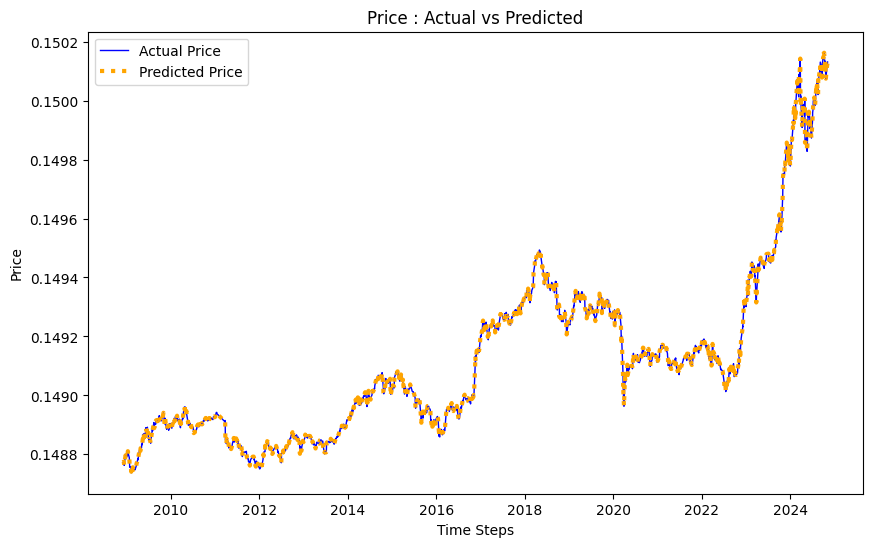

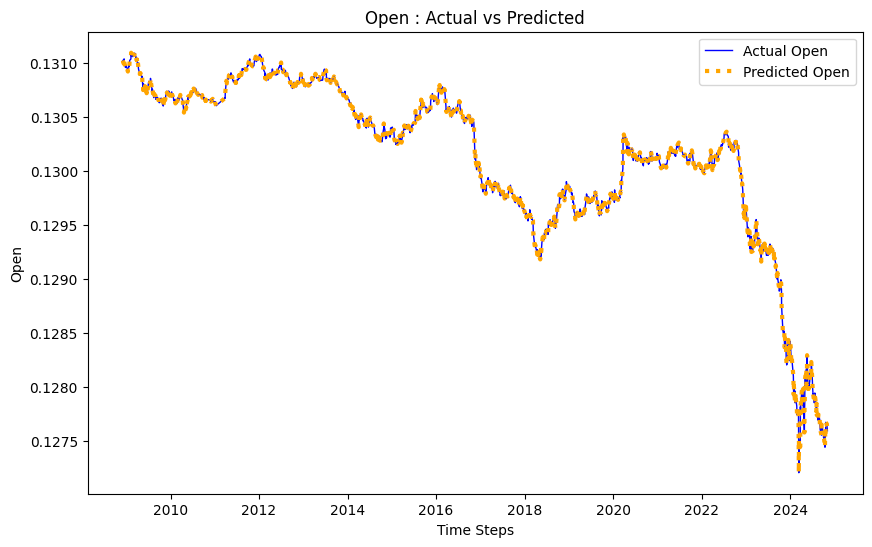

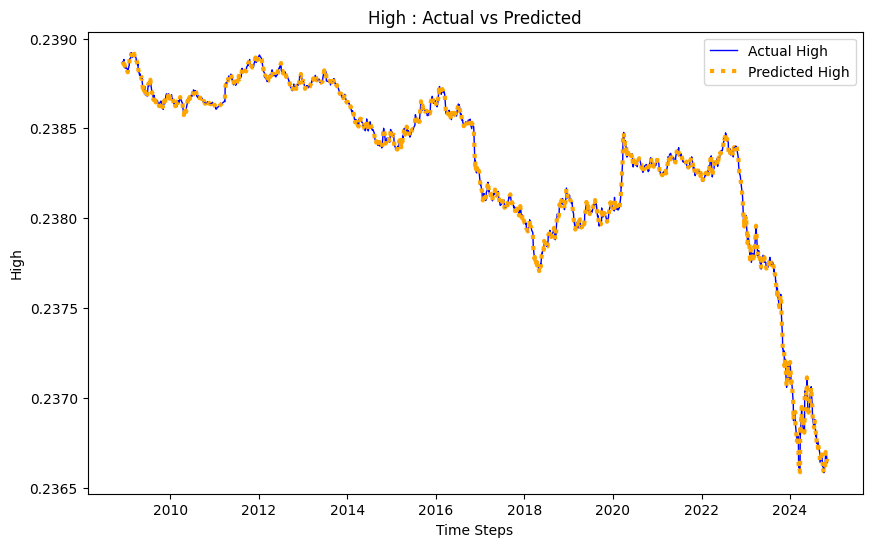

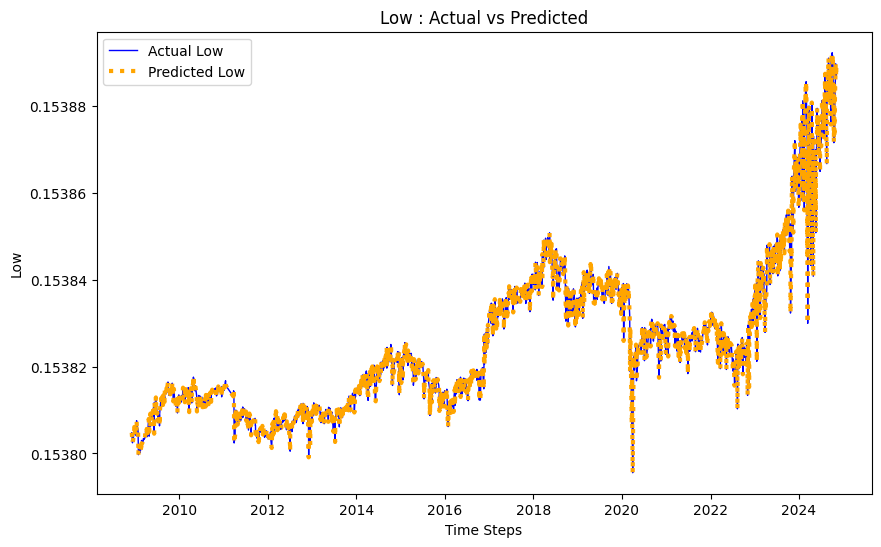

In [145]:
test_model_plot_window_GAN(
    "config_4",
    "GAN_model_2024-12-28_17-41-24_epoch_23_mse_1.3464380502700806.pth",
    "EGX 30 Historical Data_010308_280218_processed.csv",
    pred_cycle_count = 0,
    predict_earliest = False)

In [ ]:
# test_model_plot_window(
#     "config_3",
#     "model_2024-12-15_22-54-50_epoch_45_mse_0.002646987391926814.pth",
#     "EGX 30 Historical Data_010308_280218_processed.csv",
#     pred_cycle_count = 0,
#     predict_earliest = False)

In [ ]:
# test_model_plot_window(
#     "config_1",
#     "model_2024-12-14_16-05-39_epoch_30_mse_0.0037505701305538728.pth",
#     "EGX 30 Historical Data_010308_280218_processed.csv",
#     pred_cycle_count = 0
# )

In [ ]:
# test_model_plot_window(
#     "config_1",
#     "model_2024-12-01_15-40-02_epoch_35_mse_0.015517535802376057.pth",
#     "BTC_USD Bitfinex Historical Data_010318_281124_processed.csv",
#     pred_cycle_count = 0
# )

In [ ]:
# test_model_plot_window(
#     "config_2",
#     "model_2024-12-01_12-54-23_epoch_64_mse_0.010542428170863007.pth",
#     "BTC_USD Bitfinex Historical Data_010318_281124_processed.csv"
# )

Epoch [0/10000], d_loss: 1.4036, g_loss: 0.7330
Epoch [100/10000], d_loss: 1.0397, g_loss: 0.8072
Epoch [200/10000], d_loss: 0.6730, g_loss: 1.1687
Epoch [300/10000], d_loss: 0.4636, g_loss: 1.6817
Epoch [400/10000], d_loss: 0.3549, g_loss: 2.1302
Epoch [500/10000], d_loss: 0.3242, g_loss: 2.3843
Epoch [600/10000], d_loss: 0.2943, g_loss: 2.7095
Epoch [700/10000], d_loss: 0.2816, g_loss: 2.8564
Epoch [800/10000], d_loss: 0.2759, g_loss: 3.0157
Epoch [900/10000], d_loss: 0.2852, g_loss: 3.0242
Epoch [1000/10000], d_loss: 0.3022, g_loss: 3.0814
Epoch [1100/10000], d_loss: 0.2945, g_loss: 3.1394
Epoch [1200/10000], d_loss: 0.3116, g_loss: 3.2056
Epoch [1300/10000], d_loss: 0.2981, g_loss: 3.1308
Epoch [1400/10000], d_loss: 0.3133, g_loss: 3.1202
Epoch [1500/10000], d_loss: 0.3141, g_loss: 3.1092
Epoch [1600/10000], d_loss: 0.3278, g_loss: 3.0919
Epoch [1700/10000], d_loss: 0.3179, g_loss: 3.0989
Epoch [1800/10000], d_loss: 0.3233, g_loss: 3.0472
Epoch [1900/10000], d_loss: 0.3508, g_loss:

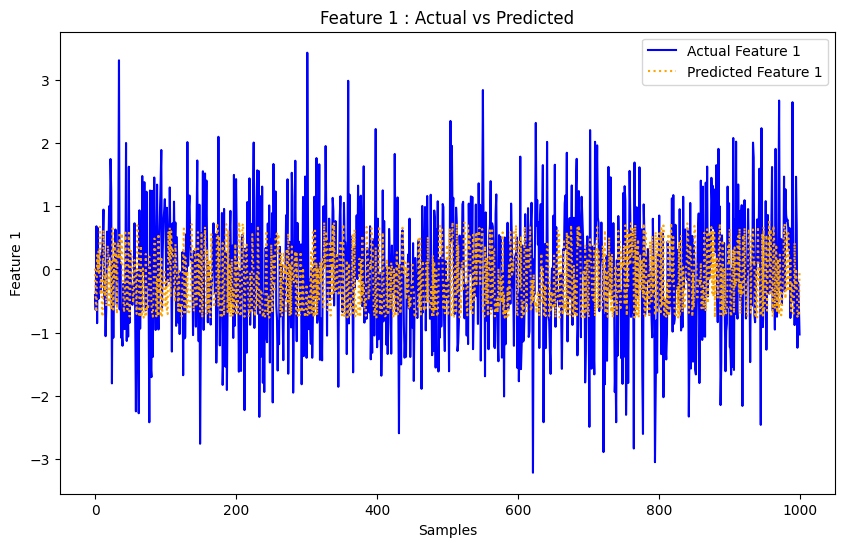

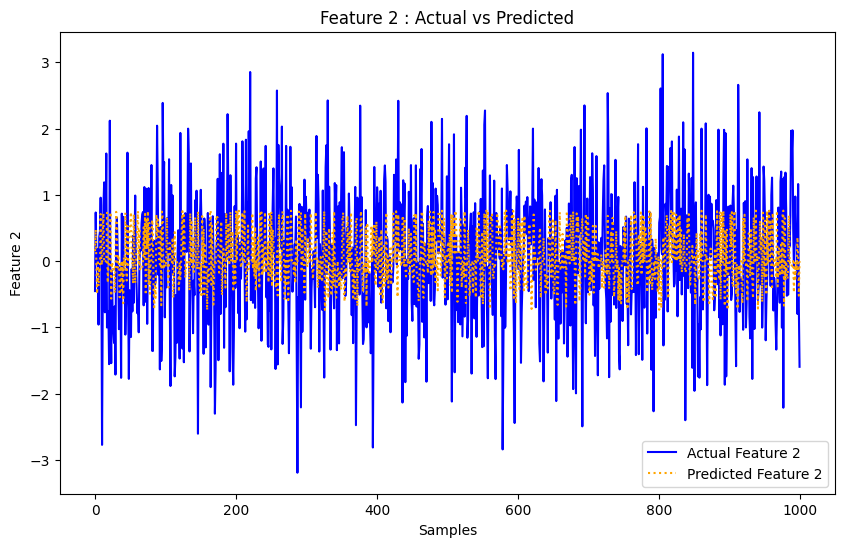

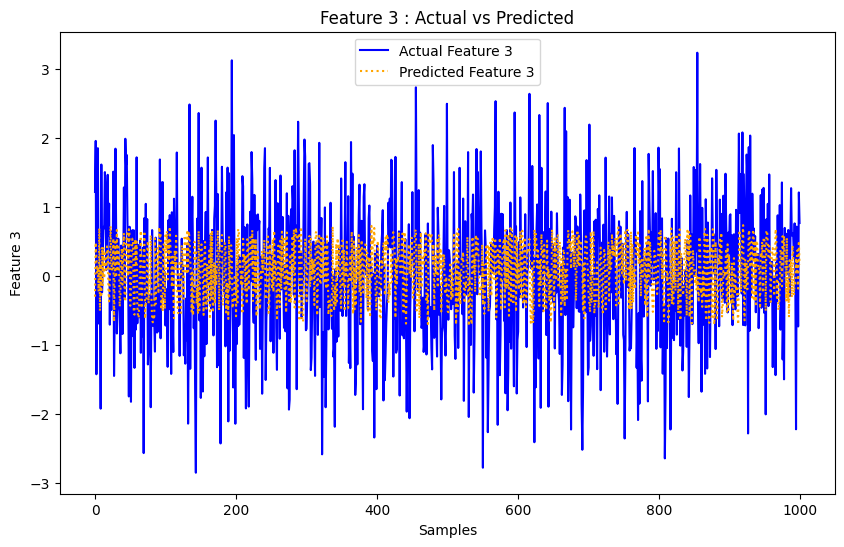

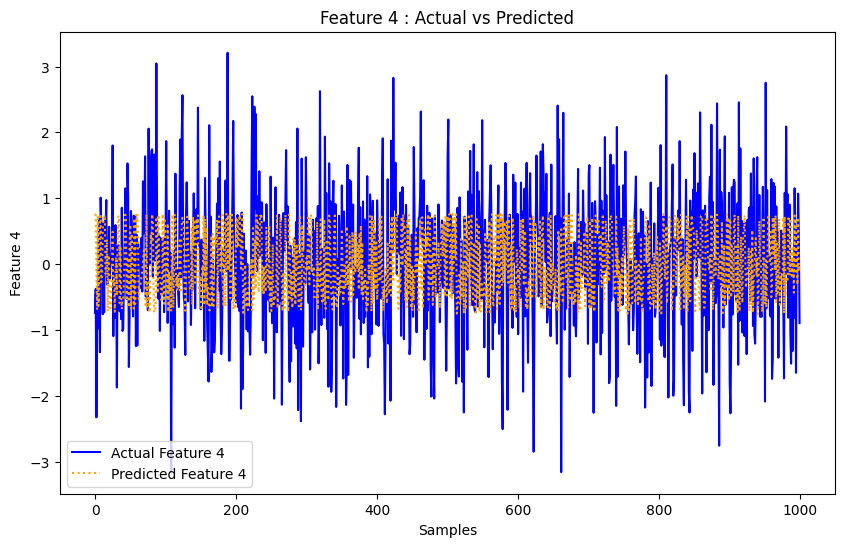

In [112]:
import torch
import numpy as np
from torchvision.ops import MLP

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate some fake data
def generate_fake_data(num_samples=1000, num_features=4):
    X = np.random.randn(num_samples, num_features)
    y = np.random.randn(num_samples, num_features)
    return X, y

# Define a simple Generator with LSTM
class SimpleGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleGenerator, self).__init__()
        self.lstm = nn.LSTM(input_dim, output_dim, batch_first=True)

    def forward(self, x):
        x, _ = self.lstm(x)
        return x

# Define a simple Discriminator using MLP from torchvision
class SimpleDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDiscriminator, self).__init__()
        self.model = MLP(input_dim, [128, 64, 1], activation_layer=nn.ReLU, dropout=0.1)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

# Training the GAN model
def train_gan(generator, discriminator, data, num_epochs=100, lr=0.0002):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

    real_data, _ = data
    real_data = torch.tensor(real_data, dtype=torch.float32).unsqueeze(1)  # Add batch dimension

    for epoch in range(num_epochs):
        # Train Discriminator
        optimizer_d.zero_grad()
        real_labels = torch.ones(real_data.size(0), 1)
        fake_data = generator(torch.randn(real_data.size(0), real_data.size(1), real_data.size(2)))
        fake_labels = torch.zeros(real_data.size(0), 1)

        real_output = discriminator(real_data.squeeze(1))
        fake_output = discriminator(fake_data.detach().squeeze(1))

        d_loss_real = criterion(real_output, real_labels)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        fake_output = discriminator(fake_data.squeeze(1))
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_g.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

# Visualize the predicted and actual data
def visualize_data(generator, data):
    real_data, _ = data
    real_data = torch.tensor(real_data, dtype=torch.float32).unsqueeze(1)  # Add batch dimension
    fake_data = generator(torch.randn(real_data.size(0), real_data.size(1), real_data.size(2))).detach().numpy().squeeze(1)

    num_features = real_data.size(2)
    for i in range(num_features):
        plt.figure(figsize=(10, 6))
        plt.plot(real_data[:, 0, i], label=f"Actual Feature {i+1}", color='blue')
        plt.plot(fake_data[:, i], label=f"Predicted Feature {i+1}", color='orange', linestyle='dotted')
        plt.title(f"Feature {i+1} : Actual vs Predicted")
        plt.xlabel("Samples")
        plt.ylabel(f"Feature {i+1}")
        plt.legend()
        plt.show()

# Main execution
num_features = 4
data = generate_fake_data(num_samples=1000, num_features=num_features)
generator = SimpleGenerator(input_dim=num_features, output_dim=num_features)
discriminator = SimpleDiscriminator(input_dim=num_features)

train_gan(generator, discriminator, data, num_epochs=10000, lr=0.0002)
visualize_data(generator, data)
